# Loading your results 
In the previous tutorials we saw how to load the published data accompanying the paper. Here we'll see how to load results that you create for your own molecules.

## Running your workflow
As explained in the README of this package, you can run your own workflow by navigating to `examples` and running `./run.sh`. To use your own molecules, simply set `smiles_list` to your SMILES strings of interest in `examples/job_info.json`. Other parameters can be changed too; we'll talk about those in the next tutorial.

## Loading workflow results
The workflow results are saved in `examples/summary.pickle`. Let's start with imports and then load the results:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import nglview as nv
from ase import Atoms
import numpy as np
from matplotlib import pyplot as plt
from ase.build.rotate import minimize_rotation_and_translation as align
import copy


In [3]:
path = "../examples/summary.pickle"
with open(path, 'rb') as f:
    info = pickle.load(f)

print(len(info))

1


It turns out that only one molecule made it to the summary, because the *trans* isomer of the other one converged to a saddle point (large imaginary frequency), and was hence excluded.

The data follows the same structure that we saw in previous tutorials:

In [4]:
keys = list(info.keys())
display(keys) # keys are SMILES strings
key = keys[0]

sub_dic = info[key]
display(list(sub_dic.keys()))

['CCN(c1ccccc1)c1cc(C(=O)NOC)ccc1/N=N\\c1ccc(C(=O)NOC)cc1N(CC)c1ccccc1']

['transition_states',
 'cis',
 'trans',
 'results_by_mechanism',
 'summary',
 'cis_smiles',
 'trans_smiles',
 'stable',
 'unstable']

The dictionary contains all the information that was in the `json` files we saw, plus `nxyz` for the geometries. For example:

In [5]:
# get the TS with the lowest free energy

ts_list = []
for this_ts_list in sub_dic['transition_states']:
    ts_list += this_ts_list
    
ts = sorted(ts_list, key=lambda x: x['free_energy'])[0]
display(list(ts.keys()))

['mechanism',
 'confnum',
 'converged',
 'entropy',
 'free_energy',
 'enthalpy',
 'vibfreqs',
 'energy',
 'nxyz',
 'ts_specific_conf_free_energy',
 'ts_specific_avg_conf_energy',
 'ts_specific_conf_entropy',
 'ts_specific_entropy',
 'ts_specific_free_energy',
 'ts_specific_enthalpy',
 'conf_free_energy',
 'avg_conf_energy',
 'conf_entropy',
 'vib_entropy',
 's_t_crossing',
 'irc_path',
 'irc_energies']

It also contains information from our IRC jobs, which we can use to check that we have a real TS:


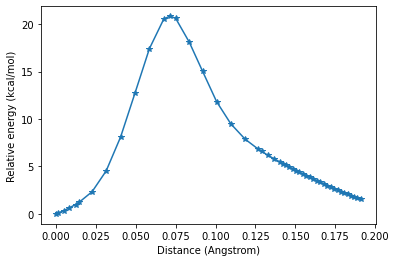

NGLWidget(max_frame=47)

In [6]:
def to_atoms(nxyz):
    nxyz = np.array(nxyz)
    atoms = Atoms(positions=nxyz[:, 1:],
                  numbers=nxyz[:, 0])
    return atoms

def get_rmsd(target, atoms):
    new_targ = copy.deepcopy(target)
    new_atoms = copy.deepcopy(atoms)
    align(new_targ, new_atoms)
    rmsd = (((new_targ.get_positions()
            - new_atoms.get_positions()) ** 2).sum() / len(new_targ)) ** 0.5
    return rmsd
    
    

irc_trj = [to_atoms(i) for i in ts['irc_path']]
irc_ens = np.array(ts['irc_energies'])
irc_ens = (irc_ens - min(irc_ens)) * 627.5
step_sizes = [get_rmsd(atoms, irc_trj[i - 1]) for i, atoms in enumerate(irc_trj)
             if i != 0]
x_vals = [0] + np.cumsum(step_sizes).tolist()

plt.plot(x_vals, irc_ens, '-*')
plt.xlabel("Distance (Angstrom)")
plt.ylabel("Relative energy (kcal/mol)")
plt.show()
display(nv.show_asetraj(irc_trj))


Notice that *trans* is still quite far from converged, due to the loose IRC convergence thresholds.

We can also look at the TS and check its frequencies:

In [7]:
atoms = to_atoms(ts['nxyz'])
display(nv.show_ase(atoms))
display(ts['vibfreqs'][:5])

NGLWidget()

[-676.2538502108795,
 10.280804310258203,
 18.636242709532894,
 21.029537611229596,
 23.045053067668473]

And we can compare the TS-specific conformational free energy with the total value:

In [8]:
ha_to_kcal = 627.5
print(ts['ts_specific_conf_free_energy'] * ha_to_kcal)
print(ts['conf_free_energy'] * ha_to_kcal) # only slightly larger in magnitude

-1.5225730303877276
-1.7077125833311462


We can look at the summary of TS quantities:

In [9]:
cis_dic = sub_dic['summary']['cis']

display(list(cis_dic.keys()))
display({key: val for key, val in cis_dic.items() if 
         not any([i in key for i in ['nxyz', 'freqs', 'irc']])})

trj = [to_atoms(cis_dic['endpoint_nxyz']), to_atoms(cis_dic['ts_nxyz'])]
display(nv.show_asetraj(trj))

irc_trj = [to_atoms(i) for i in cis_dic['irc_path']]
display(nv.show_asetraj(irc_trj))



['ts_nxyz',
 'endpoint_nxyz',
 'delta_free_energy',
 'delta_energy',
 'delta_enthalpy',
 'delta_conf_free_energy',
 'delta_avg_conf_energy',
 'delta_entropy_j_mol_k',
 'delta_conf_entropy_j_mol_k',
 'delta_vib_entropy_j_mol_k',
 'endpoint_conf_free_energy',
 'ts_conf_free_energy',
 'mechanism',
 'confnum',
 'irc_energies',
 'irc_path']

{'delta_free_energy': 30.507829167013607,
 'delta_energy': 34.5287134447445,
 'delta_enthalpy': 31.79561419826464,
 'delta_conf_free_energy': -0.07470365651806114,
 'delta_avg_conf_energy': 0.2569389710023909,
 'delta_entropy_j_mol_k': 18.071751033890052,
 'delta_conf_entropy_j_mol_k': 1.0483317084406099,
 'delta_vib_entropy_j_mol_k': 17.02341932544941,
 'endpoint_conf_free_energy': -0.002602406371704517,
 'ts_conf_free_energy': -0.0027214543160655716,
 'mechanism': 'right_rot',
 'confnum': 1}

NGLWidget(max_frame=1)

NGLWidget(max_frame=47)

The quantities are the same as in the previous tutorials, with the addition of `irc_path` and `irc_energies`, plus `mechanism` and `confnum` for bookeeping (here the mechanism is a "left" rotation, and it's the conformer that was originally ranked 5th during conformer generation, but became 1st after eigenvector following).

Let's take a look at the singlet-triplet crossings:

In [10]:
key = list(info.keys())[0]
sub_dic = info[key]

unstable = sub_dic['unstable']
print("Unstable side: %s" % unstable)

summary = sub_dic['summary']
s_t_dic = summary['s_t_crossing']
stable_s_t = s_t_dic['stable_side']
unstable_s_t = s_t_dic['unstable_side']

display({key: val for key, val in unstable_s_t.items() if 
         'nxyz' not in key})

Unstable side: cis


{'delta_free_energy': 30.073152376335447,
 'delta_energy': 33.88131416801363,
 'delta_enthalpy': 31.283544074735488,
 'delta_conf_free_energy': -0.07470365651806114,
 'delta_avg_conf_energy': 0.2569389710023909,
 'delta_eff_free_energy': 32.301753092272875,
 'delta_entropy_j_mol_k': 16.985674546724006,
 'delta_conf_entropy_j_mol_k': 1.0483317084406099,
 'delta_vib_entropy_j_mol_k': 15.937342838283362,
 'delta_eff_entropy_j_mol_k': -14.28873563433339,
 'endpoint_conf_free_energy': -0.002602406371704517,
 's_t_crossing_conf_free_energy': -0.0027214543160655716,
 'endpoint': 'cis',
 't_isc': 4.1991980009597345e-12}

In [11]:
nxyz_list = [s_t_dic['unstable_side']['endpoint_nxyz'],
             s_t_dic['unstable_side']['s_t_crossing_nxyz'],
             s_t_dic['stable_side']['s_t_crossing_nxyz']]
trj = [to_atoms(i) for i in nxyz_list]
display(nv.show_asetraj(trj))

NGLWidget(max_frame=2)

And there you go: you've run a full workflow for your own molecules and analyzed your results!